---
title: Assignment 04
author:
  - name: Bhargavi Manyala
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: today
date-modified: today
date-format: long
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
engine: jupyter
jupyter: assignment-04-kernel
execute:
  echo: true
  eval: true
  output: true
  freeze: auto
---

# Load the Dataset

In [34]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np
from pyspark.sql.functions import col, pow
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when, expr, trim, regexp_replace
from pyspark.sql.functions import col, sum
import matplotlib.pyplot as plt


np.random.seed(42)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = (
    spark.read
    .option("header", "true")
    .option("inferSchema", "true")
    .option("multiLine", "true")
    .option("escape", "\"")  
    .csv("data/lightcast_job_postings.csv")

)

df.createOrReplaceTempView("job_postings")
#df.show(5)


# Feature Engineering

### Take Columns needed for the analysis

+------+--------------------+--------------------+--------+-------------------+-------------+----------+----------------+----------------------+-------------------+------------------+
|SALARY|MIN_YEARS_EXPERIENCE|MAX_YEARS_EXPERIENCE|DURATION|COMPANY_IS_STAFFING|IS_INTERNSHIP|STATE_NAME|REMOTE_TYPE_NAME|EMPLOYMENT_TYPE_NAME  |MIN_EDULEVELS_NAME |MAX_EDULEVELS_NAME|
+------+--------------------+--------------------+--------+-------------------+-------------+----------+----------------+----------------------+-------------------+------------------+
|NULL  |2                   |2                   |6       |false              |false        |Arkansas  |[None]          |Full-time (> 32 hours)|Bachelor's degree  |NULL              |
|NULL  |3                   |3                   |NULL    |true               |false        |Maine     |Remote          |Full-time (> 32 hours)|No Education Listed|NULL              |
|NULL  |5                   |NULL                |35      |false              |f

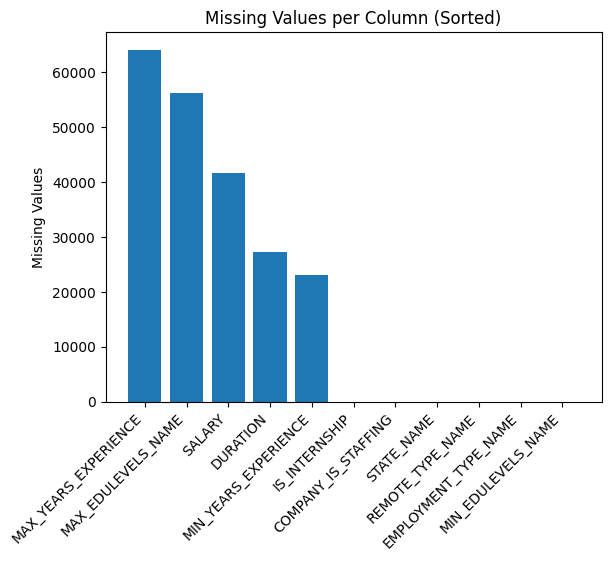

+------+--------------------+--------+-------------------+-------------+----------+----------------+----------------------+-------------------+
|SALARY|MIN_YEARS_EXPERIENCE|DURATION|COMPANY_IS_STAFFING|IS_INTERNSHIP|STATE_NAME|REMOTE_TYPE_NAME|EMPLOYMENT_TYPE_NAME  |MIN_EDULEVELS_NAME |
+------+--------------------+--------+-------------------+-------------+----------+----------------+----------------------+-------------------+
|NULL  |2                   |6       |false              |false        |Arkansas  |[None]          |Full-time (> 32 hours)|Bachelor's degree  |
|NULL  |3                   |NULL    |true               |false        |Maine     |Remote          |Full-time (> 32 hours)|No Education Listed|
|NULL  |5                   |35      |false              |false        |Texas     |[None]          |Full-time (> 32 hours)|Bachelor's degree  |
|NULL  |3                   |48      |false              |false        |Arizona   |[None]          |Full-time (> 32 hours)|No Education 

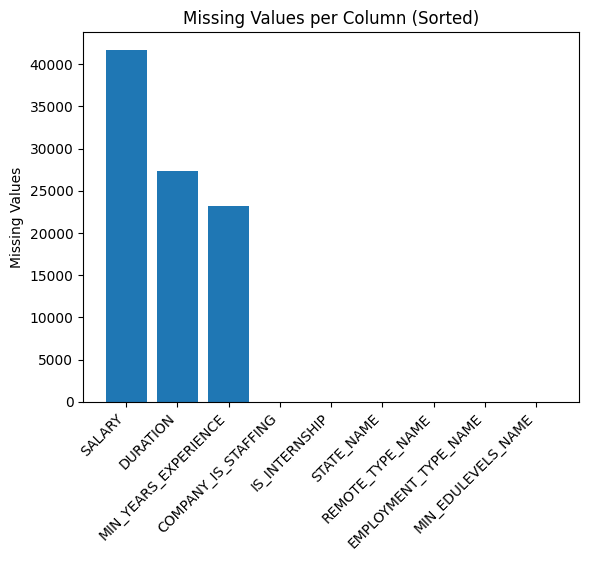

In [35]:
subset_cols = [
    "SALARY", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "DURATION",
    "COMPANY_IS_STAFFING", "IS_INTERNSHIP",
    "STATE_NAME", "REMOTE_TYPE_NAME", "EMPLOYMENT_TYPE_NAME",
    "MIN_EDULEVELS_NAME", "MAX_EDULEVELS_NAME"
]

subset_df = df.select(subset_cols)
subset_df.show(5, truncate=False)


missing = subset_df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in subset_df.columns
]).toPandas()

missing = missing.T.reset_index()
missing.columns = ["column", "missing_count"]


missing = missing.sort_values(by="missing_count", ascending=False)

plt.bar(missing["column"], missing["missing_count"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Missing Values")
plt.title("Missing Values per Column (Sorted)")
plt.show()


# Define the subset of columns
subset_final_cols = [
    "SALARY",
    "MIN_YEARS_EXPERIENCE", 
    "DURATION",
    "COMPANY_IS_STAFFING", 
    "IS_INTERNSHIP",
    "STATE_NAME", 
    "REMOTE_TYPE_NAME", 
    "EMPLOYMENT_TYPE_NAME",
    "MIN_EDULEVELS_NAME"
]


subset_final_df = df.select(subset_final_cols)
subset_final_df.show(5, truncate=False)

missing = subset_final_df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in subset_final_df.columns
]).toPandas()


missing = missing.T.reset_index()
missing.columns = ["column", "missing_count"]

missing = missing.sort_values(by="missing_count", ascending=False)

plt.bar(missing["column"], missing["missing_count"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Missing Values")
plt.title("Missing Values per Column (Sorted)")
plt.show()


### Define categorical columns to analyze


In [ ]:

# Change Remote Type Name
subset_final_df = subset_final_df.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "[None]", "Undefined")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "On Premise")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when(col("REMOTE_TYPE_NAME").isNull(), "On Premise")
    .otherwise(col("REMOTE_TYPE_NAME"))
)

subset_final_df.createOrReplaceTempView("subset_final_df")

categorical_cols = [
    "STATE_NAME", "REMOTE_TYPE_NAME", "EMPLOYMENT_TYPE_NAME",
    "MIN_EDULEVELS_NAME", "COMPANY_IS_STAFFING", "IS_INTERNSHIP"
]

for colname in categorical_cols:
    print(f"\n---- {colname} ----")
    subset_final_df.select(colname).distinct().show(truncate=False)




---- STATE_NAME ----


+-------------+
|STATE_NAME   |
+-------------+
|Utah         |
|Hawaii       |
|Minnesota    |
|Ohio         |
|Arkansas     |
|Oregon       |
|Texas        |
|North Dakota |
|Pennsylvania |
|Connecticut  |
|Nebraska     |
|Vermont      |
|Nevada       |
|Washington   |
|Illinois     |
|Oklahoma     |
|Delaware     |
|Alaska       |
|New Mexico   |
|West Virginia|
+-------------+
only showing top 20 rows


---- REMOTE_TYPE_NAME ----


+----------------+
|REMOTE_TYPE_NAME|
+----------------+
|Remote          |
|On Premise      |
|Hybrid          |
|Undefined       |
+----------------+


---- EMPLOYMENT_TYPE_NAME ----


+------------------------+
|EMPLOYMENT_TYPE_NAME    |
+------------------------+
|Part-time / full-time   |
|Part-time (â‰¤ 32 hours)|
|Full-time (> 32 hours)  |
|NULL                    |
+------------------------+


---- MIN_EDULEVELS_NAME ----


+----------------------------+
|MIN_EDULEVELS_NAME          |
+----------------------------+
|Bachelor's degree           |
|Ph.D. or professional degree|
|High school or GED          |
|Master's degree             |
|No Education Listed         |
|Associate degree            |
|NULL                        |
+----------------------------+


---- COMPANY_IS_STAFFING ----


+-------------------+
|COMPANY_IS_STAFFING|
+-------------------+
|true               |
|false              |
|NULL               |
+-------------------+


---- IS_INTERNSHIP ----


+-------------+
|IS_INTERNSHIP|
+-------------+
|true         |
|false        |
|NULL         |
+-------------+



In [37]:
subset_final_df = subset_final_df.withColumn(
    "REMOTE_TYPE_NAME",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "[None]", "Undefined")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "On Premise")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when(col("REMOTE_TYPE_NAME").isNull(), "On Premise")
    .otherwise(col("REMOTE_TYPE_NAME"))
)

subset_final_df.createOrReplaceTempView("subset_final_df")

